# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [1]:
import numpy as np
import csv
import cv2
import pickle 
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import matplotlib.gridspec as gridspec
%matplotlib inline

---
## Step 0: Load The Data

In [2]:
def one_hot_encode(train_labels, test_labels):
    encoder = LabelBinarizer()  #initialize object
    encoder.fit(train_labels)   #feed the labels so it develops the encoder
    
    # translate to one-hot 
    train_labels = encoder.transform(train_labels)
    test_labels = encoder.transform(test_labels)
    
    # Change type to float 32, so they can multuplied against the feature matrix
    train_labels = train_labels.astype(np.float32)
    test_labels = test_labels.astype(np.float32)
    return train_labels, test_labels

In [3]:
# Load pickle data
PATH = "traffic-signs-data/"
training_file = PATH + os.listdir(PATH)[1]
testing_file = PATH + os.listdir(PATH)[0]

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']
assert(len(X_train) == len(y_train))
assert(len(X_test) == len(y_test))

# Create one-hot encoded labeled data for testing and training sets
y_train_labels, y_test_labels = one_hot_encode(y_train, y_test)
print('Labels One-Hot Encoded')

# Load sign names and ID pairings into a dictionary
with open('signnames.csv') as csvfile:
    reader = csv.DictReader(csvfile)
    sign_names = dict()
    for row in reader:
        sign_names[int(row['ClassId'])] = row['SignName']

Labels One-Hot Encoded


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [4]:
# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
#load the csv file and find its length
n_classes = len(sign_names.keys())

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape,"- (height, width, channels)")
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3) - (height, width, channels)
Number of classes = 43


###  Visualizing Traffic Signs and Useful  Observations
 
Training images are grouped by tracks. Each track contains 30 samples of physical traffic signs with usually increasing resolution as the camera is approaching the sign. There are a total of 43 different classes of traffic signs in this data set, and the number of samples per class is shown in the bar graph below. It is clear that training set is imbalanced. For best performance  generation of synthetic examples  for each class of traffic sign is necessary.

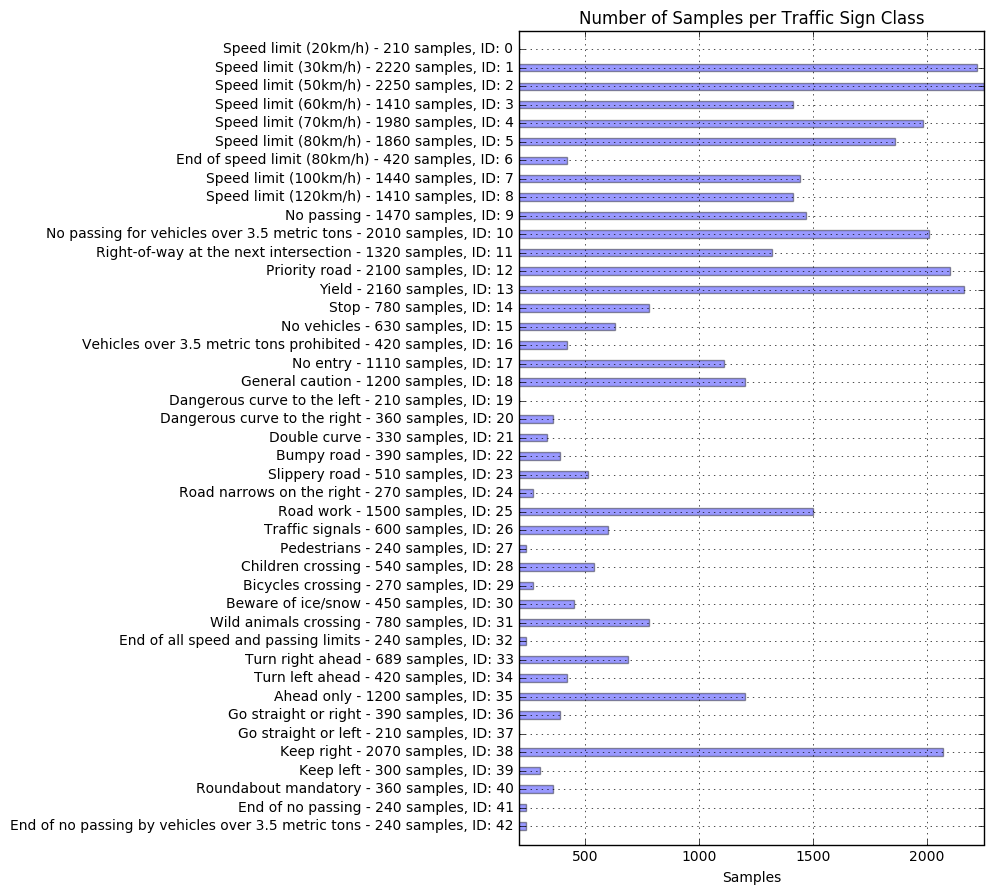

In [5]:
# Display number of samples per traffic sign class in a horizontal bar chart
sign_classes = list(sign_names.values())[::-1]
class_counts = np.bincount(y_train)[::-1]
y_pos = np.arange(0, len(class_counts)*10, 10)        
for index in range(class_counts.shape[0]):
    sign_classes[index] = sign_classes[index] + " - " + str(class_counts[index]) + " samples, ID: " + str(abs(index-42))
    
plt.figure(figsize=(6,10.5))
plt.xlabel('Samples')
plt.title('Number of Samples per Traffic Sign Class')

plt.grid(True)
plt.barh(y_pos, class_counts,height=4, align='center', alpha=0.4)

plt.yticks(y_pos, sign_classes)
plt.xlim([min(class_counts) - 0.5, max(class_counts) + 0.5])
plt.ylim([min(y_pos) - 10, max(y_pos) + 10])
plt.show()

A sample of each of the 43 different classes of traffic signs with their corresponding class ID are shown. By cycling through various samples from different tracks the following challenges were revealed:

* wide array of lighting conditions such as shadows and sun glare
* poor resolution
* occlusion
* motion-blur and sign orientation
* sign vandalism
* worn out signs

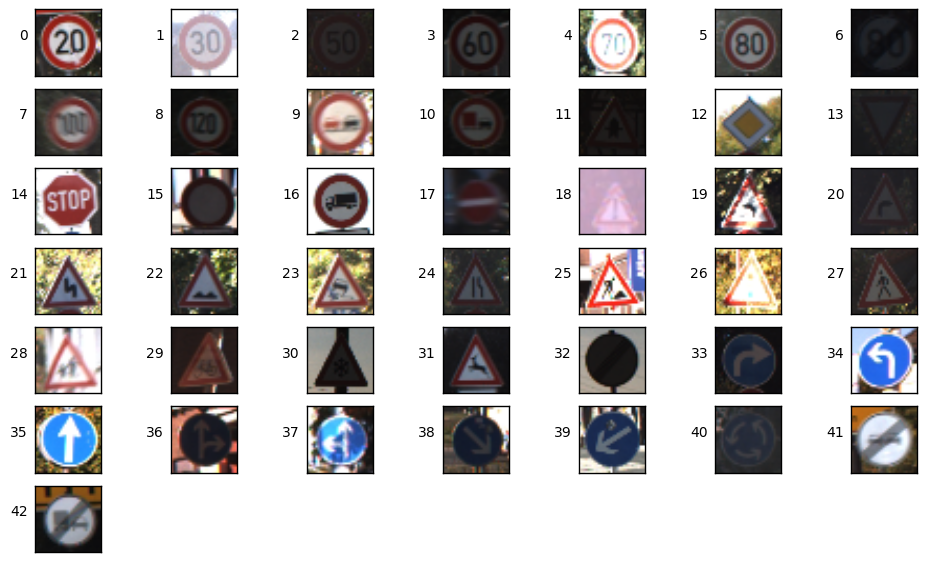

In [6]:
# Display an example of each traffic sign class with corresponding ID
IDs, indeces = np.unique(y_train, return_index=True)
plt.figure(figsize=(12,7))
for ID, index in zip(IDs,indeces):
    plt.subplot(7, 7, ID+1)
    plt.yticks([], [])
    plt.xticks([], [])
    plt.ylabel(ID, rotation=0, horizontalalignment='right')
    plt.imshow(X_train[index+25])

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Data Preprocessing 

Preparing data before feeding into the neural network:

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer**

To preprocess the data:

1. **Convert from  RGB to Grayscale colorspace:** Many variances in lighting make the use of color information unreliable.  Traffic signs are simple enough that it would greatly simplify the model by ignoring color information and focusing shapes. Used OpenCV `cvtColor`.

2. **Equalize Intesity Histogram:** Poor lighting makes it hard to distinguish the shape's edges. This distributes the intesity of the pixel values more evenly increasing image contrast.  Used  OpenCV `equalizeHist`

3. **Normalized pixel data between 0.1 and 0.9:** Helps gradient descent converge faster as values are not spread over a large range. Helps reduce image noise.

In [7]:
# Min-Max scaling for grayscale image data range of [0.1, 0.9]
def normalize_grayscale(image):
    a, b = 0.1, 0.9
    x_max, x_min =  np.amax(image), np.amin(image)
    normalized_image = a + ((image - x_min) * (b - a))/(x_max - x_min)
    return normalized_image

def preprocess_image(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)     # 1.grayscale image
    image = cv2.equalizeHist(image).astype(float)       # 2.equalize histogram to increase contrast
    return normalize_grayscale(image)                   # 3.normalized data between [0.1, 0.9]

In [8]:
# preprocess training data
X_train_gray = np.zeros((X_train.shape[0], 32, 32), dtype=np.float32)
for index in range(X_train.shape[0]):
    X_train_gray[index] = preprocess_image(X_train[index])
    
# preprocess test data
X_test_gray = np.zeros((X_test.shape[0], 32, 32), dtype=np.float32)
for index in range(X_test.shape[0]):
    X_test_gray[index] = preprocess_image(X_test[index])

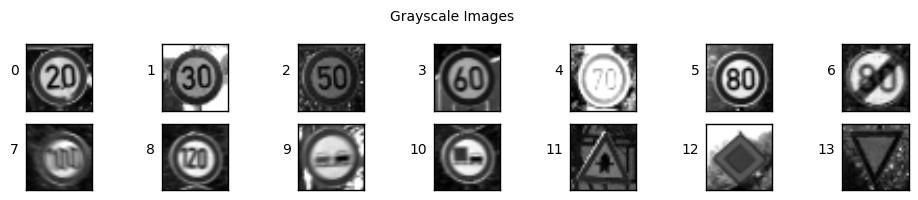

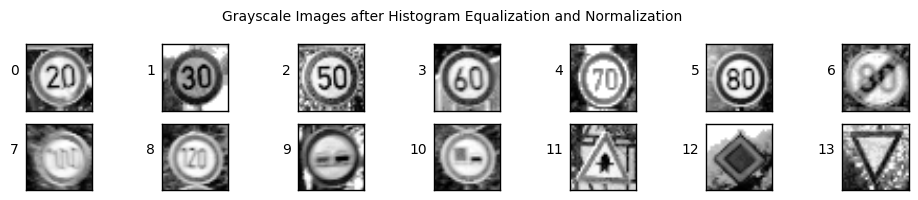

In [9]:
# Plot grayscale sample images without normalization and histogram equalization
plt.figure(figsize=(12,7)).suptitle("Grayscale Images", y=.95)
for ID, index in zip(IDs[0:14],indeces[0:14]):
    plt.subplot(7, 7, ID+1)
    plt.yticks([], [])
    plt.xticks([], [])
    plt.ylabel(ID, rotation=0, horizontalalignment='right')
    plt.imshow(cv2.cvtColor(X_train[index+25], cv2.COLOR_RGB2GRAY), cmap='gray')

# Plot preprocessed sample images
plt.figure(figsize=(12,7)).suptitle("Grayscale Images after Histogram Equalization and Normalization", y=.95)
for ID, index in zip(IDs[0:14],indeces[0:14]):
    plt.subplot(7, 7, ID+1)
    plt.yticks([], [])
    plt.xticks([], [])
    plt.ylabel(ID, rotation=0, horizontalalignment='right')
    plt.imshow(X_train_gray[index+25], cmap='gray') 

###  Data Preparation, Generation and  Augmentation

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer**

To prepare the training, validation and testing data:

1. **Create a Validation Set**: Split 10% the preproccessed training data to create a validation set. We do this before generating  extra data as we dont't want mix synthetic and real data.

2. **Generate Extra Samples**: As seen the bar graph above there is an uneven distribution of samples accross the 43 different classes. Some classes have too few examples such as the 20km/hr speed limit class. To create additional samples for these types of classes, a jittered dataset was made by adding 5 transformed versions of each image in the preprocessed training set, yielding a total of 176440 samples. The ratio of images between classes was kept the same as there was no single majority class in this dataset.

3. **Data Augmentation**: To create the jittered data set, three Affine Transformations were applied to the 5 extra versions of each image. These random pertubations will help the models ability to generalize, increasing performance. Affine Transformations:
    - Rotation: +/- 15 degrees 
    - Translation: +/- 2 pixels 
    - Shearing: +/- 2.5 pixels
    
    **note:** In previous training rounds the data augmentation values were higher. These high values were affecting the performance of the neural net by distorting the image to the point that image features were hard to distinguish. Performance greatly improved after the augmentation values were reduced.
    
    Affine Transformations - https://en.wikipedia.org/wiki/Affine_transformation)

In [10]:
# Get randomized datasets for training and validation 90-10 split
train_features, valid_features, train_labels, valid_labels = train_test_split(
    X_train_gray,
    y_train_labels,
    test_size=0.10,
    random_state=832289)

In [11]:
def rotate_image(image, rot_angle):
    h, w = image.shape
    center =(h/2, w/2) 
    
    rot_angle = np.random.uniform(high=rot_angle, low=-rot_angle) 
    M = cv2.getRotationMatrix2D(center, rot_angle, 1.0)             #rotation matrix
    return cv2.warpAffine(image, M, (w, h))                         #apply rotation
    
def translate_image(image, trans_dist):
    h, w = image.shape
    
    # Translation matrix [[1 0 tx], [0 1 ty]]
    tx = np.random.uniform(high=trans_dist, low=-trans_dist) #horizontal translation distance in pixels
    ty = np.random.uniform(high=trans_dist, low=-trans_dist) #vertical translation distance in pixels
    M = np.float32([[1, 0, tx], [0, 1, ty]])                        
    return cv2.warpAffine(image, M, (w,h))                   #apply translation                           

def shear_image(image, shear_range):
    h, w = image.shape
    
    pts1 = np.float32([[5,5],[20,5],[5,20]])
    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2
    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])
    
    M = cv2.getAffineTransform(pts1,pts2)                     #shear matrix
    return cv2.warpAffine(image, M,(w, h))                    #apply shear

def transform_image(image, rot_angle, trans_dist, shear_range):
    image = rotate_image(image, rot_angle)                    #rotate image
    image = translate_image(image, trans_dist)                #translate image
    image = shear_image(image, shear_range)                   #shear image
    return image

def generate_augmented_samples(image_data, image_labels, rot_angle, trans_dist, shear_range, copies=5):
    # Generate 5 copies of each image in the training set
    image_data = np.repeat(image_data, repeats=5, axis=0)
    print(image_data.shape)
    image_labels = np.repeat(image_labels, repeats=5, axis=0)
    
    # Transform images in new training set
    for index in range(image_data.shape[0]):
        image_data[index] = transform_image(image_data[index], rot_angle, trans_dist, shear_range)
        
    # Shuffle data
    image_data, image_labels = shuffle(image_data, image_labels)
    return image_data, image_labels

**Generate Synthetic Data**

In [12]:
rot_angle = 15
trans_dist = 2
shear_range = 2.5

train_features, train_labels = generate_augmented_samples(train_features, train_labels, 
                                                          rot_angle, trans_dist, shear_range)

(176440, 32, 32)


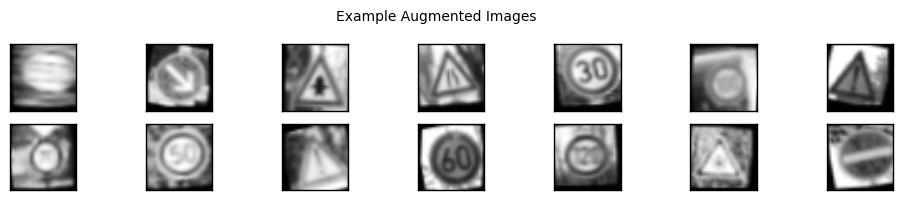

In [13]:
plt.figure(figsize=(12,7)).suptitle("Example Augmented Images", y=.95)
random_indeces = [np.random.randint(len(train_features)) for r in range(14)]
count = 1
for index in random_indeces:
    plt.subplot(7, 7, count)
    plt.yticks([], [])
    plt.xticks([], [])
    plt.imshow(train_features[index].squeeze(), cmap='gray') 
    count +=1

**Augmented Data Summary**

In [14]:
# TODO: Number of training examples
n_train = train_features.shape[0]
# TODO: Number of training examples
n_valid = valid_features.shape[0]

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)

Number of training examples = 176440
Number of validation examples = 3921


## CNN Architecture

### Tested Architectures
The following table has network architectures based on LeNet-5 that were tested using a *13" MBP w Retina display 13" base model*. For each test, the networks were run for a maximum of **25 Epochs**  due to  limited computing power.

|Test ID| Architecture  |  Validation Accuracy	| 
|---  |---	|---	|---	|
|   1 |  LeNet-5, plug and play	|  93.4% 	|   	
|  2  |  Dropout after every layer	|  57.5% 	|   	
|  3  |  Dropout after each fully connected layer	|83.4%   	|   	
|  4  |  Filter size change to 3X3 in conv layers	|  94.3% 	|   	  
|  5  |  Conv layers filter size 3X3 with Multiscale features	| 92.3%  	|   	 
|  6  |  Conv layers filter size 3X3, increased fliters in conv layer 1 and 2 (32 and 64 respectively) |  96.6% | 
|  7  |  Conv layers filter size 3X3, increased fliters in conv layer 1 and 2 (32 and 64 respectively) with Multiscale Features |  95.2% | 
|  8  |  Conv layers filter size 3X3, increased fliters in conv layer 1 and 2 (32 and 64 respectively) with Multiscale Features with dropout in all layers |  95.4% | 
|  9 |  Conv layers filter size 3X3, increased fliters in conv layer 1 and 2 (32 and 64 respectively) with Multiscale Features, revised augmented dataset |  98.5% | 
|  10 |  Conv layers filter size 3X3, increased fliters in conv layer 1 and 2 (32 and 64 respectively) with Multiscale Features, revised augmented dataset, and 3rd conv layer with 128 filters|  99.0% | 

**Observations**:
- Dropout is not as effective in with small neural nets (small number of parameters)
- smaller filter sizes in convolution layers boosted perfomance as  it enables the network to focus on finer features relative to image resolution and acts a regularizer
- 3rd convolutional layer boosts training performance by extracting higher level features for the classifier

**Additional Improvements**:
- Add inception modules or simple 1x1 convolutions as a cheap way to deepen the neural net
___
### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._

**Answer**:

### Input
Similar to LeNet architecture, it accepts a 32x32x1 image as input. Input images are grayscale.

## Architecture

**Layer 1: Convolution.** Filter Size: 3x3. Filter Depth: 32. Output shape should be 30x30x32.

** Relu Activation.** 

**2x2 Max-Pooling.** The output shape should be 15x15x32.


----
**Layer 2: Convolution.** Filter Size: 3x3. Filter Depth: 64. Output shape should be 13x13x64.

** Relu Activation.** 

**2x2 Max-Pooling.** The output shape should be 6x6x64.

----
**Layer 3: Convolution.** Filter Size: 2x2. Filter Depth: 128. Output shape should be 4x4x128.

** Relu Activation.** 

**2x2 Max-Pooling.** The output shape should be 2x2x128.

----
**Flatten.** Flatten the output of each convolution layer after max-pooling

** Muli-Scale Features.** Concatanate flattened layers and then feed to fully connected layers. Size: 10016

----
**Layer 4: Fully Connected.** 1024 outputs.

** Relu Activation.** 

**Layer 5: Fully Connected.** 512 outputs.

**Relu Activation.**

----

### Output
**Layer 6: Fully Connected (Logits).** 43 outputs, for 43 classes


In [15]:
def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID')
    return tf.nn.bias_add(x, b)
   
def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='VALID')

def dropout(x, keep_prob):
    return tf.nn.dropout(x, keep_prob)

In [16]:
n_classes = 43
filter_depth = {
    'layer_1': 32,
    'layer_2': 64,
    'layer_3': 128,
    'fc1': 1024,
    'fc2': 512   
}

def LeNet(x, keep_prob):    
    #Hyperparameters
    mu = 0
    sigma = 0.1

    # Layer 1: Convolutional. Input = 32x32x1. Output = 30x30x32.
    layer1_W = tf.Variable(tf.truncated_normal((3,3,1,filter_depth['layer_1']), mean=mu, stddev=sigma))
    layer1_b = tf.Variable(tf.zeros(filter_depth['layer_1']))
    layer1 = conv2d(x, layer1_W, layer1_b)
    
    # Activation.
    layer1 = tf.nn.relu(layer1)
    
    # Pooling. Input = 30x30x32. Output = 15x15x32.
    layer1 = maxpool2d(layer1)
      
    # Layer 2: Convolutional. Input = 15x15x32 Output = 13x13x64.
    layer2_W = tf.Variable(tf.truncated_normal((3,3,filter_depth['layer_1'],filter_depth['layer_2']), mean=mu, stddev=sigma))
    layer2_b = tf.Variable(tf.zeros(filter_depth['layer_2']))
    layer2 = conv2d(layer1, layer2_W, layer2_b)
    
    # Activation.
    layer2 = tf.nn.relu(layer2)
    
    # Pooling. Input = 13x13x64. Output = 6x6x64. 
    layer2 = maxpool2d(layer2)
    
    # Layer 3: Convolutional. Input = 6x6x64 Output = 4x4x128.
    layer3_W = tf.Variable(tf.truncated_normal((2,2,filter_depth['layer_2'],filter_depth['layer_3']), mean=mu, stddev=sigma))
    layer3_b = tf.Variable(tf.zeros(filter_depth['layer_3']))
    layer3 = conv2d(layer2, layer3_W, layer3_b)
    
    # Activation.
    layer3 = tf.nn.relu(layer3)
    
    # Pooling. Input = 4x4x128. Output = 2x2x128. 
    layer3 = maxpool2d(layer3)
    
    # Flatten Layer 1. Input = 15x15x32. Output = 7200
    # Flatten Layer 2. Input = 6x6x64. Output = 2304
    # Flatten Layer 3. Input = 2x2x128. Ouput = 512
    # Concatanate Layer1, Layer 2, and layer 3 Features
    flat_layer1 = flatten(layer1)
    flat_layer2 = flatten(layer2)
    flat_layer3 = flatten(layer3)
    fc0 = tf.concat(1,[flat_layer1, flat_layer2, flat_layer3])
    
    # Layer 4: Fully Connected. Input = 2304. Output = 1024.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(10016, filter_depth['fc1']), mean=mu, stddev=sigma))
    fc1_b = tf.Variable(tf.zeros(filter_depth['fc1']))
    fc1 = tf.add(tf.matmul(fc0, fc1_W), fc1_b)
    
    # Activation.
    fc1 = tf.nn.relu(fc1)
    
    # Layer 5: Fully Connected. Input = 1024. Output = 1024.
    fc2_W = tf.Variable(tf.truncated_normal(shape=(filter_depth['fc1'], filter_depth['fc2']), mean=mu, stddev=sigma))
    fc2_b = tf.Variable(tf.zeros(filter_depth['fc2']))
    fc2 = tf.add(tf.matmul(fc1, fc2_W), fc2_b)

    # Activation.
    fc2 = tf.nn.relu(fc2)
    
    # Layer 6: Fully Connected. Input = 512. Output = 43.
    fc3_W = tf.Variable(tf.truncated_normal(shape=(filter_depth['fc2'], n_classes), mean=mu, stddev=sigma))
    fc3_b = tf.Variable(tf.zeros(n_classes))
    logits = tf.add(tf.matmul(fc2, fc3_W), fc3_b)
    
    return logits

## Training 

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_

**Answer:**

To train the model I used the following....

**Hyperameters**:
- batch size: 128 (personal pc not computationaly efficient)
- learining rate: 0.001
- Epochs:  15

**Preventing Over Training**:
-  To prevent overfitting the data I manually kept track of the validation and loss and accuracy. If I didnt see any significant improvement on these two parameters for 10,000 training iterations (about 7 epochs  using a batch size of 128) I stopped the training and reduced the number of epochs and re-trained the model. This method is not efficient, but it's doable for this specific project. A more robust approaoch would be to write my own early stopping algorithm or used the one provided by the  tensorflow api.

**Optimizer**:
- Adam optimizer with default parameters. training usually

### Features and Labels

* `x` is a placeholder for a batch  of  input images
* `y` is placeholder for a  batch of ouput labels

In [17]:
x = tf.placeholder(tf.float32,(None, 32, 32, 1))
y = tf.placeholder(tf.float32,(None, 43))

# Add dimension to train and validation. Input Shape [None,32,32]. Output Shape [None,32,32,1]
train_features = np.reshape(train_features, (train_features.shape[0],32,32,-1))
valid_features = np.reshape(valid_features, (valid_features.shape[0],32,32,-1))

### Training  Pipeline

In [18]:
# Training parameters to tune
learn_rate = 0.001
BATCH_SIZE = 128
EPOCHS = 15

In [19]:
keep_prob = tf.placeholder(tf.float32)

# Logits
logits = LeNet(x, keep_prob)

# Softmax
softmax = tf.nn.softmax(logits)

# Cross Entropy
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, y)

# Training Loss
loss_operation = tf.reduce_mean(cross_entropy)

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate = learn_rate)
training_operation = optimizer.minimize(loss_operation)

### Model Evaluation
Evaluate model based on Validation loss and accuracy

In [20]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_batches = num_examples/BATCH_SIZE
    total_accuracy = 0
    validation_loss = 0
    sess = tf.get_default_session() ## get the current session without being an input to the function
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy, loss = sess.run([accuracy_operation, loss_operation], feed_dict={x: batch_x, y: batch_y, keep_prob: 1})
        total_accuracy += (accuracy * len(batch_x))
        validation_loss += loss
    return (total_accuracy / num_examples), (validation_loss/total_batches)

### Model Training

In [21]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())             #initialize variables
    num_examples = len(train_features)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        # Shuffle data before each EPOCH
        # Feeding the data in the same order will affects the model's ability to generalize
        train_features, train_labels = shuffle(train_features, train_labels)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = train_features[offset:end], train_labels[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1})
        
        # Print Validation accuracy after each EPOCH    
        validation_accuracy, validation_loss = evaluate(valid_features, valid_labels)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Validation Loss = {:.3f}".format(validation_loss))
        print()
        
    # Save Model
    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    saver.save(sess, 'LeNet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.966
Validation Loss = 0.112

EPOCH 2 ...
Validation Accuracy = 0.984
Validation Loss = 0.053

EPOCH 3 ...
Validation Accuracy = 0.984
Validation Loss = 0.052

EPOCH 4 ...
Validation Accuracy = 0.980
Validation Loss = 0.071

EPOCH 5 ...
Validation Accuracy = 0.985
Validation Loss = 0.057

EPOCH 6 ...
Validation Accuracy = 0.980
Validation Loss = 0.099

EPOCH 7 ...
Validation Accuracy = 0.990
Validation Loss = 0.052

EPOCH 8 ...
Validation Accuracy = 0.990
Validation Loss = 0.041

EPOCH 9 ...
Validation Accuracy = 0.990
Validation Loss = 0.048

EPOCH 10 ...
Validation Accuracy = 0.981
Validation Loss = 0.113

EPOCH 11 ...
Validation Accuracy = 0.985
Validation Loss = 0.068

EPOCH 12 ...
Validation Accuracy = 0.989
Validation Loss = 0.065

EPOCH 13 ...
Validation Accuracy = 0.989
Validation Loss = 0.053

EPOCH 14 ...
Validation Accuracy = 0.989
Validation Loss = 0.063

EPOCH 15 ...
Validation Accuracy = 0.989
Validation Loss = 0.087

Model 

### Evaluate Model

In [22]:
test_features = np.reshape(X_test_gray, (X_test_gray.shape[0],32,32,-1))  #resize test features to (none,32,32,1)
with tf.Session() as sess:
    loader = tf.train.import_meta_graph('LeNet.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))

    test_accuracy, test_loss = evaluate(test_features, y_test_labels)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    print("Test Loss = {:.3f}".format(test_loss))

Test Accuracy = 0.952
Test Loss = 0.367


## Results

**Validation Accuracy**:  99.0%

**Test Accuracy**:  95.2%

Difference suggests overffiting, but it is not extreme. Reduce number of Epochs to close the gap.


## Reflection

### Question 5

_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

I first read Yann Lecun's [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf), and Daniel Nouri's blog post on [using convolutional neural nets to detect facial features](http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/#conclusion).From the Yann Lecun's paper, I implemented  data augmentation and generation and decide to use grayscale images to boost performance (this remained constant through most NN architectures.

I first used the LENET-5 architecture with the augmented training set and recorded it's validation accuracy as a baseline. In addition, using LeNet-5 architecture as a foundation, I did several experiments where I added  multiscale features, increased the number of filers in the convolutional layer, changed filter size, and tried max-pooling dropout. I tried several combinations and recorded their performance on the validation set. Validation performance never exceeded more than 96% on the different combinations of the architectures. The problem stemmed from  over-augmenting the training set to the point that image features were hard to distinguish due to distortion. From these tests I learned a few important things:
    - Dropout is not effective on small networks(low amount of features)
    - Reducing  filter size is a cheap way to regularize the network and a way of focusing on finer image features
    - Be careful of not over-augmenting the training set data!
    
I reduced the magnitude of the affine transformations in the augemented data set, and based on the data gathered I decided that the most effective network would include: smaller filter sizes and increased filters in the convolution layers, multiscale features, no dropout, and an extra convlution layer to extract higher level features as traffic signs have higher complexity than the MNIST dataset (LeNet-5 intended use)

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._

**Answer**:
Since I live in the United States, I decided to use local traffic signs. I picked a total of 5 images from the internet based on the following criteria:
*  Image should be from an actual street sign
*  At least one sign should be almost exactly the same as in the german data set to use as a control sample (*Yield*)
*  Signs that share the same inner figure, but deffer in outward shape (*Contruction Ahead, Do Not Enter, Slippery Road Ahead*)
*  Speed limit with the same numeric value as in the german dataset(*70 mph speed limit*)

Overall I want to evaluate how much impact did the outward shape/features of the traffic sign has in its classification 

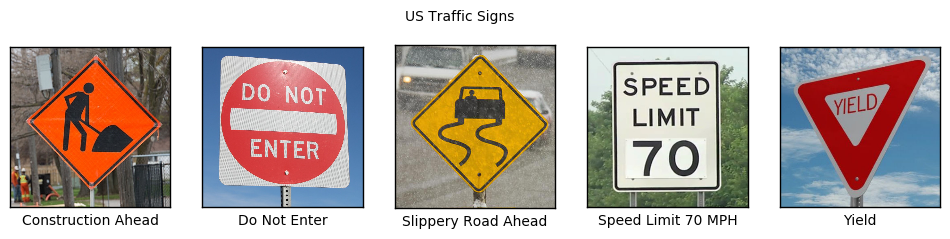

In [23]:
# Load images file names
PATH2 = "US-traffic-signs/"
image_files = os.listdir(PATH2)[1:]

# Plot Images
plt.figure(figsize=(12,7)).suptitle("US Traffic Signs", y=.68)
for index in range(5):
    img = cv2.cvtColor(cv2.imread(PATH2+image_files[index]), cv2.COLOR_BGR2RGB)
    plt.subplot(1, 5, index+1)
    plt.yticks([], [])
    plt.xticks([], [])
    plt.xlabel(image_files[index][:-4], rotation=0)
    plt.imshow(img)

### Run Test Images Through the CNN

In [24]:
# Load preprocessesd images into a data matrix to feed into the Neural Net
test_images = np.zeros((5,32,32), dtype=np.float32)
for file, index in zip(image_files, range(5)):
    image = cv2.imread(PATH2+file)
    image = cv2.resize(image,(32,32))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = preprocess_image(image)
    test_images[index] = image

In [25]:
top_5_pred = tf.nn.top_k(softmax, 5)       # Tensor to obtain the top five predictions for each image

In [26]:
test_images = np.reshape(test_images, (5,32,32,-1))  #resize test features to (5,32,32,1)

# Runn images through model
with tf.Session() as sess:
    loader = tf.train.import_meta_graph('LeNet.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))
    predictions, top_5 = sess.run([softmax,top_5_pred], feed_dict = {x: test_images, keep_prob: 1})

### Predictions

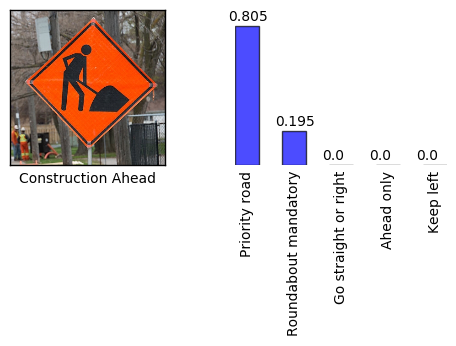

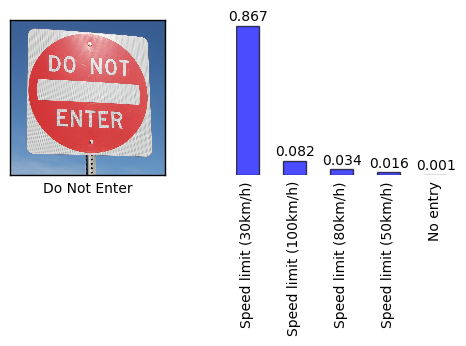

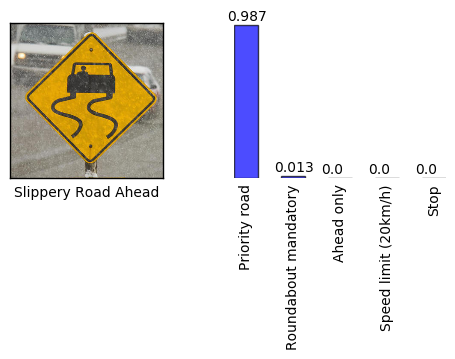

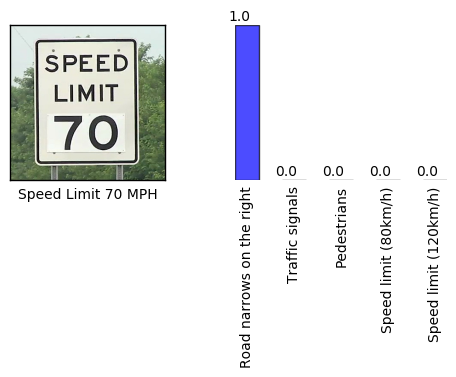

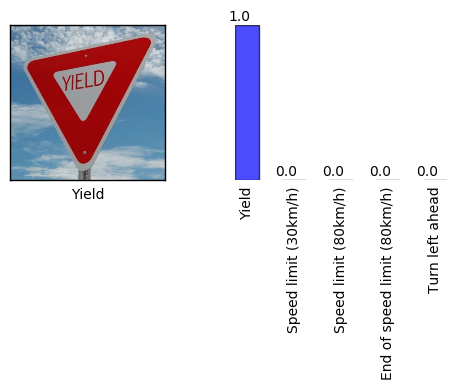

In [27]:
for index in range(5):
    # Plot original Traffic sign image
    plt.figure(figsize=(6,2))
    gs = gridspec.GridSpec(1,2)
    img = cv2.cvtColor(cv2.imread(PATH2+image_files[index]), cv2.COLOR_BGR2RGB)
    plt.subplot(gs[0])
    plt.yticks([], [])
    plt.xticks([], [])
    plt.xlabel(image_files[index][:-4], rotation=0)
    plt.imshow(img)
    
    # Plot top 5 softmax probabilities/predictions
    ax = plt.subplot(gs[1])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    plt.bar(6-np.arange(5), top_5[0][index][::-1], align='edge', alpha=0.7, width=.5)
    for i_label in range(5):
        plt.text(6-i_label-.15, top_5[0][index][::-1][i_label] +.03, round(top_5[0][index][::-1][i_label],3))
        
    # Label probabilites with correspondig traffic sign name
    prediction_names = [list(sign_names.values())[i] for i in top_5[1][index]][::-1]
    plt.xticks(6-np.arange(5)+.25, prediction_names, rotation='vertical')
    plt.tick_params( axis='x', which='both', top='off', bottom='off', labelbottom='on')
    plt.yticks([], [])
    plt.show()

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._

**Answer:**

The model performed poorly on the US traffic signs examples. It guessed 1/5 with absolute certainty for a 20% accuracy. The model performs well on signs that share the same outward shape, but fails to generalize when traffic signs share the same inner figure with different outward shape. A clear example of this  are the predictions for the construction ahead and slippery road ahead signs. The model predicts with the highest probability that it is equivalent to the German priority road sign. Interestingly these three traffic signs share the same outward shape.


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

**Answer:**
The model predicted the Yield sign with the highest certainty. The other four predictions were wrong, but interestingly enough, they showed higher certainty predictions on signs that shared similar outward shapes. 
